# Homework 1, Problem 4: Integration

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def integrand(x):
    return np.square(np.sin(np.sqrt(100*x)))

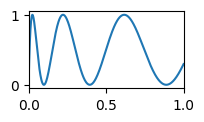

In [2]:
x = np.linspace(0,1,num=500)
y = integrand(x)
assert(len(x) == len(y))

fig, ax = plt.subplots()
fig.set_size_inches(2,1)

plt.plot(x, y)
plt.xlim(0,1)
plt.show()

In [3]:
def trapezoid_rule(left, right, integrand):
    width = right - left
    return (integrand(left) + integrand(right)) * width / 2

def half_the_trapezoid_width(a, b, num_subintervals, integrand, error, previous):
    width = (b-a)/num_subintervals
    lefts = np.linspace(a, b-width, num=num_subintervals)
    rights = np.linspace(a+width, b, num=num_subintervals)
    sum = np.sum(trapezoid_rule(lefts, rights, integrand))
    this_error = abs(previous - sum) / 3
    if this_error <= error:
        return sum, num_subintervals
    return half_the_trapezoid_width(a, b, num_subintervals*2, integrand, error, sum)

# method to calculate a definite integral given lower limit a, upper limit b, and integrand integrand
def adaptive_trapezoid_rule(a, b, integrand):
    first_estimate = trapezoid_rule(a, b, integrand)
    error = 1e-6
    return half_the_trapezoid_width(a, b, 2, integrand, error, first_estimate)


In [4]:
def half_the_trapezoid_width_spedup(a, b, num_subintervals, integrand, error, previous):
    width = (b-a)/num_subintervals
    midpoints = np.linspace(a+width, b-width, num=int(np.round(num_subintervals/2)))
    sum = previous/2 + width*np.sum(integrand(midpoints))
    this_error = abs(previous - sum) / 3
    if this_error <= error:
        return sum, num_subintervals
    return half_the_trapezoid_width(a, b, num_subintervals*2, integrand, error, sum)

def adaptive_trapezoid_rule_spedup(a, b, integrand):
    first_estimate = trapezoid_rule(a, b, integrand)
    error = 1e-6
    return half_the_trapezoid_width_spedup(a, b, 2, integrand, error, first_estimate)

integral, n = adaptive_trapezoid_rule(0,1,integrand)
print(f"Adaptive Trapezoid: {integral}\n{'':20}{n} subintervals")
integral, n = adaptive_trapezoid_rule_spedup(0,1,integrand)
print(f"{'Sped-up':>18}: {integral}\n{'':20}{n} subintervals")

from time import time
sum = [0,0]
functions = [adaptive_trapezoid_rule, adaptive_trapezoid_rule_spedup]
for i in range(10000):
    for j in range(2):
        begin = time()
        functions[j](0,1,integrand)
        end = time()
        sum[j] = end-begin
speedup_percent = (sum[1]/sum[0] - 1)*100
print(f"{'':20}{speedup_percent:.4f}% speedup")

Adaptive Trapezoid: 0.4558320582782708
                    4096 subintervals
           Sped-up: 0.4558320582782708
                    4096 subintervals
                    -3.0030% speedup


The speed-up varies, sometimes +/- 30%, but more often -5 to +5%. There appears to be no appreciable speed-up in this implementation from eq. 5, and in fact it may cause a slow-down.

In [5]:
def trapezoid_subintervals(a, b, num_subintervals, integrand):
    width = (b-a)/num_subintervals
    lefts = np.linspace(a, b-width, num=num_subintervals)
    rights = np.linspace(a+width, b, num=num_subintervals)
    return np.sum(trapezoid_rule(lefts, rights, integrand))

def romberg_integration(a, b, integrand):
    error_max = 1e-6

    R_im = [[trapezoid_rule(a, b, integrand)]]
    error = 1
    i = 0
    while(error > error_max):
        i += 1
        R_im.append([0]*(i+1))
        R_im[i][0] = trapezoid_subintervals(a, b, 2**i, integrand)
        for m in range(i):
            R_im[i][m+1] = R_im[i][m] + (R_im[i][m] - R_im[i-1][m]) / (4**(m+1)-1)
        
        '''
        A note on error.
        I originally implemented the error as written in eq. 7:
            error = (R_im[i][i] - R_im[i-1][i]) / (4**(i+1)-1)
        This formulation means that in order to calculate the error for a
        diagonal element, such as R_{2,2}, you would need to know elements
        in the upper right triangle, such as R_{1,2}. Clearly, this is not
        a correct interpretation, as Romberg integration is a lower left
        triangular algorithm. Instead, I have implemented a simple error
        measure, that should at least get you into the right order of
        magnitude.
        '''

        error = abs(R_im[i-1][i-1] - R_im[i][i])
        
    return R_im[i][i], 2**i

integral, n = romberg_integration(0,1,integrand)
print(f"Romberg Integration: {integral}\n{'':21}{n} subintervals")


Romberg Integration: 0.45583253230501364
                     128 subintervals


Romberg integration has 32x fewer subintervals needed in this case than adaptive trapezoid rule.

For Gauss-Legendre quadrature, first transform the integral's bounds into [-1,1] using $x = 1/2 + z/2$.

$$ I = \int_{-1}^1 \sin^2\left( \sqrt{100(1/2 + z/2)}\right) \frac{1}{2}dz$$

In [6]:
def integrand_z(x):
    return np.square(np.sin(np.sqrt(100*(1/2 + x/2))))/2

# weights: location
# from https://pomax.github.io/bezierinfo/legendre-gauss.html
gauss_legendre_7 = {
    0.4179591836734694: 0.0000000000000000,
    0.3818300505051189: 0.4058451513773972,
    0.3818300505051189: -0.4058451513773972,
    0.2797053914892766:	-0.7415311855993945,
    0.2797053914892766:	0.7415311855993945,
    0.1294849661688697: -0.9491079123427585,
    0.1294849661688697: 0.9491079123427585,
}

gauss_legendre_14 = {
    0.2152638534631578:	-0.1080549487073437,
 	0.2152638534631578:	0.1080549487073437,
 	0.2051984637212956:	-0.3191123689278897,
 	0.2051984637212956:	0.3191123689278897,
 	0.1855383974779378:	-0.5152486363581541,
 	0.1855383974779378:	0.5152486363581541,
 	0.1572031671581935:	-0.6872929048116855,
 	0.1572031671581935:	0.6872929048116855,
 	0.1215185706879032:	-0.8272013150697650,
 	0.1215185706879032:	0.8272013150697650,
 	0.0801580871597602:	-0.9284348836635735,
 	0.0801580871597602:	0.9284348836635735,
 	0.0351194603317519:	-0.9862838086968123,
 	0.0351194603317519:	0.9862838086968123
}

def gauss_legendre(points, integrand):
    return np.sum([w*integrand(l) for w, l in points.items()])


integral = gauss_legendre(gauss_legendre_7, integrand_z)
print(f"Gauss-Legendre: {integral}\n{'':16}7 quadrature points")
integral = gauss_legendre(gauss_legendre_14, integrand_z)
print(f"{'':16}{integral}\n{'':16}14 quadrature points")

Gauss-Legendre: 0.2228041018167432
                7 quadrature points
                0.2423978094859687
                14 quadrature points


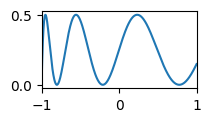

In [7]:
x = np.linspace(-1,1,num=500)
y = integrand_z(x)
assert(len(x) == len(y))

fig, ax = plt.subplots()
fig.set_size_inches(2,1)

plt.plot(x, y)
plt.xlim(-1,1)
plt.show()